# VAERepresentations - Agent

In [1]:
import os, datetime
import numpy as np
import matplotlib.pyplot as plt
import joblib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer,text_to_word_sequence

## Collect HTML files

Load the HTML files

In [2]:
files = []

for f in os.listdir(os.path.join(os.getcwd(),'html')):
    fd = open(os.path.join(os.getcwd(),'html',f),'r')
    content = fd.read()
    files.append(content)
    fd.close()

Add a mock file as a concatentation of a previous one

In [3]:
files.append(files[0]*10)

## Preprocess the files

Define the padding and trimming parameters

In [4]:
padding='post'

maxlen=200
truncating='post'

Load the tokenizer

Show an example of tokenization

In [5]:
SQLi_tokenizer = joblib.load('ignore_tokenizer_20210318105336141483')

Convert the pages into token sequences:

In [6]:
tokens_list = SQLi_tokenizer.texts_to_sequences(files)

Pad and trim the sequences to fit them into an array:

In [7]:
tokens_array = keras.preprocessing.sequence.pad_sequences(tokens_list, padding=padding, maxlen=maxlen, truncating=truncating)

## Defining VAE

Instantiating a VAE module built following [https://keras.io/examples/generative/vae/](https://keras.io/examples/generative/vae/).

*Sampling layer with reparametrization trick* $z_i\sim\mathcal{N}(\mu_\phi, \sigma_\phi)$

In [8]:
class Sampling(layers.Layer):
    
    def call(self,inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
        return z_mean + tf.exp(.5 * z_log_var) * epsilon

*Encoder* $Q_\phi(z \vert x)$

In [9]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(200,))

x = layers.Dense(100,activation='relu')(encoder_inputs)
x = layers.Dense(25,activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean,z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean,z_log_var,z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          20100       input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 25)           2525        dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            52          dense_1[0][0]                    
____________________________________________________________________________________________

*Decoder* $P_\theta(x\vert z)$

In [10]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(25,activation='relu')(latent_inputs)
x = layers.Dense(100,activation='relu')(x)
decoder_outputs = layers.Dense(200,activation='relu')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 200)               20200     
Total params: 22,875
Trainable params: 22,875
Non-trainable params: 0
_________________________________________________________________


*VAE with KL+reconstruction loss*

In [11]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)           
            reconstruction = self.decoder(z)
            print(reconstruction)
            reconstruction_loss = keras.losses.mean_squared_error(data,reconstruction)
            #reconstruction_loss = tf.reduce_sum(keras.losses.mean_squared_error(data,reconstruction), axis=1)
            kl_loss = -.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = (tf.reduce_sum(kl_loss,axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads,self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

## Loading the VAE

Loading the model weights

In [13]:
vae = VAE(encoder,decoder)
vae.load_weights('ignore_vae_W_20210317111205281453')

Checking the weights

## Define a mock server

We import and instantiate a new server.

In [14]:
import SQLiServer
env = SQLiServer.mockSQLienv(files)

In [15]:
env.reset()

('\n<!-- saved from url=(0033)http://jabba.hackingarena.no:806/ -->\n<html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"></head><body>Login as admin for the flag!\n\n<form action="http://jabba.hackingarena.no:806/index.php" method="post">\n<table width="100">\n<tbody><tr><td>Name:</td>\n<td><input type="text" name="username" value=""></td></tr>\n<tr><td>Password:</td>\n<td><input type="text" name="passwd" value=""></td></tr>\n\n<tr><td><input type="submit" value="Submit"></td></tr>\n</tbody></table>\n</form>\n\n</body></html>',
 0,
 False,
 'env reset')

## Running an agent

In [16]:
n_episodes = 1000

n_actions = 10
S0S1 = 2; S1S2 = 3

In [17]:
class Agent():
    
    def __init__(self,vae,n_actions,verbose=True):       
        self.n_actions = n_actions
        self.vae = vae
        
        self.state = np.array([0.,0.])
        self.Q = {self.state.tobytes(): np.ones(self.n_actions)} 
        
        self.total_trials = 0
        self.total_successes = 0
        
        self.verbose = verbose
             
    def set_learning_options(self,exploration=0.2,learningrate=0.1,discount=0.9,max_step=100):
        self.expl = exploration
        self.lr = learningrate
        self.discount = discount 
        self.max_step = max_step
        
    def _select_action(self):
        if (np.random.random() < self.expl):
            return np.random.randint(0,self.n_actions)        
        else:
            return np.argmax(self.Q[self.state.tobytes()])
        
    def step(self):
        self.steps = self.steps+1
        action = self._select_action()
        
        response,reward,termination,s = self.env.step(action)
        self.rewards = self.rewards + reward
        
        self._analyze_response(action,response,reward)
        self.terminated = termination
        if(self.verbose): print(s)
        
        return    
        
    
    def reset(self,env):
        self.env = env  
        self.terminated = False                     
        
        self.steps = 0
        self.rewards = 0
        
                
    def run_episode(self):
        _,_,self.terminated,s = self.env.reset()
        if(self.verbose): print(s)
        
        while not(self.terminated) and self.steps < self.max_step:
            self.step()
            #if(self.steps>500): self.terminated=True
            
        self.total_trials += 1
        if(self.terminated):
            self.total_successes += 1      
    
            
    def _analyze_response(self,action,response,reward):
        tokens = SQLi_tokenizer.texts_to_sequences([response])
        tokens = keras.preprocessing.sequence.pad_sequences(tokens, padding=padding, maxlen=maxlen, truncating=truncating)
        
        newstate = self.vae.encoder(tokens)[0].numpy()[0]       
        self._update_Q(self.state,newstate,action,reward)
        self.state = newstate
            
    def _update_Q(self,oldstate,newstate,action,reward):
        
        if(newstate.tobytes() in self.Q.keys()):
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        else:
            self.Q[newstate.tobytes()] = np.ones(self.n_actions)
            best_action_newstate = np.argmax(self.Q[newstate.tobytes()])
        
        self.Q[oldstate.tobytes()][action] = self.Q[oldstate.tobytes()][action] + self.lr * (reward + self.discount*self.Q[newstate.tobytes()][best_action_newstate] - self.Q[oldstate.tobytes()][action])

In [18]:
agent = Agent(vae1,n_actions)
agent.set_learning_options()

In [19]:
steps = []
rewards = []

for _ in range(n_episodes):
    
    env = SQLiServer.mockSQLienv(files,actions=n_actions,S0S1=S0S1,S1S2=S1S2,verbose=False)
    agent.reset(env)
    
    agent.run_episode()
    steps.append(agent.steps)
    rewards.append(agent.rewards)

env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
wrong request
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
correct escape
correct escape
flag
env reset
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wrong request
wron

flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
wrong request
correc

correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wro

correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct

wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
correct escape
flag
env reset
wrong 

correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
correct escape
wrong request
correct escape
wrong request
correct escape
flag
env reset
wrong request
wrong

correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
correct escape
flag
env reset
wrong request
wrong request
correct escape
flag


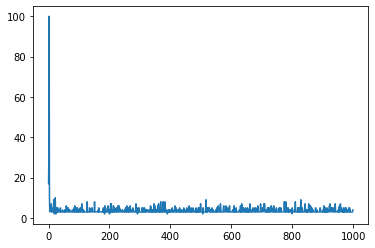

In [20]:
plt.plot(steps)